## Модели прогнозирования объема убоя КРС по Акмолинской области

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Подготовка данных и EDA

In [2]:
df = pd.read_excel("Датасет по КРС.xlsx")
df.head(5)

,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,9.8,372560.0,-12.490323
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,9.8,399442.0,-10.192857
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,8.3,425605.0,-5.870968
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,8.8,440023.0,4.490000
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,42.8,444647.0,14.574194


In [3]:
df_akmola = df[df['Регион'] == 'АКМОЛИНСКАЯ ОБЛАСТЬ']
df_akmola = df_akmola.drop('Регион', axis = 'columns')
df_akmola.head()

,Период,КРС,Осадки,Поголовье: КРС,Температура
0,2015-01,4455.35,9.8,372560.0,-12.490323
1,2015-02,3654.20,9.8,399442.0,-10.192857
2,2015-03,4287.08,8.3,425605.0,-5.870968
3,2015-04,3923.21,8.8,440023.0,4.490000
4,2015-05,3849.70,42.8,444647.0,14.574194


In [4]:
df_akmola = df_akmola.rename(columns={'КРС': 'Объем убоя: КРС'})
df_akmola.head()

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
0,2015-01,4455.35,9.8,372560.0,-12.490323
1,2015-02,3654.20,9.8,399442.0,-10.192857
2,2015-03,4287.08,8.3,425605.0,-5.870968
3,2015-04,3923.21,8.8,440023.0,4.490000
4,2015-05,3849.70,42.8,444647.0,14.574194


In [5]:
df_akmola['Период'] = pd.to_datetime(df_akmola['Период'], format='%Y-%m')

In [6]:
df_akmola.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Период           120 non-null    datetime64[ns]
 1   Объем убоя: КРС  120 non-null    float64       
 2   Осадки           120 non-null    float64       
 3   Поголовье: КРС   120 non-null    float64       
 4   Температура      120 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.6 KB


In [7]:
df_akmola.isna().sum()

Период             0
Объем убоя: КРС    0
Осадки             0
Поголовье: КРС     0
Температура        0
dtype: int64

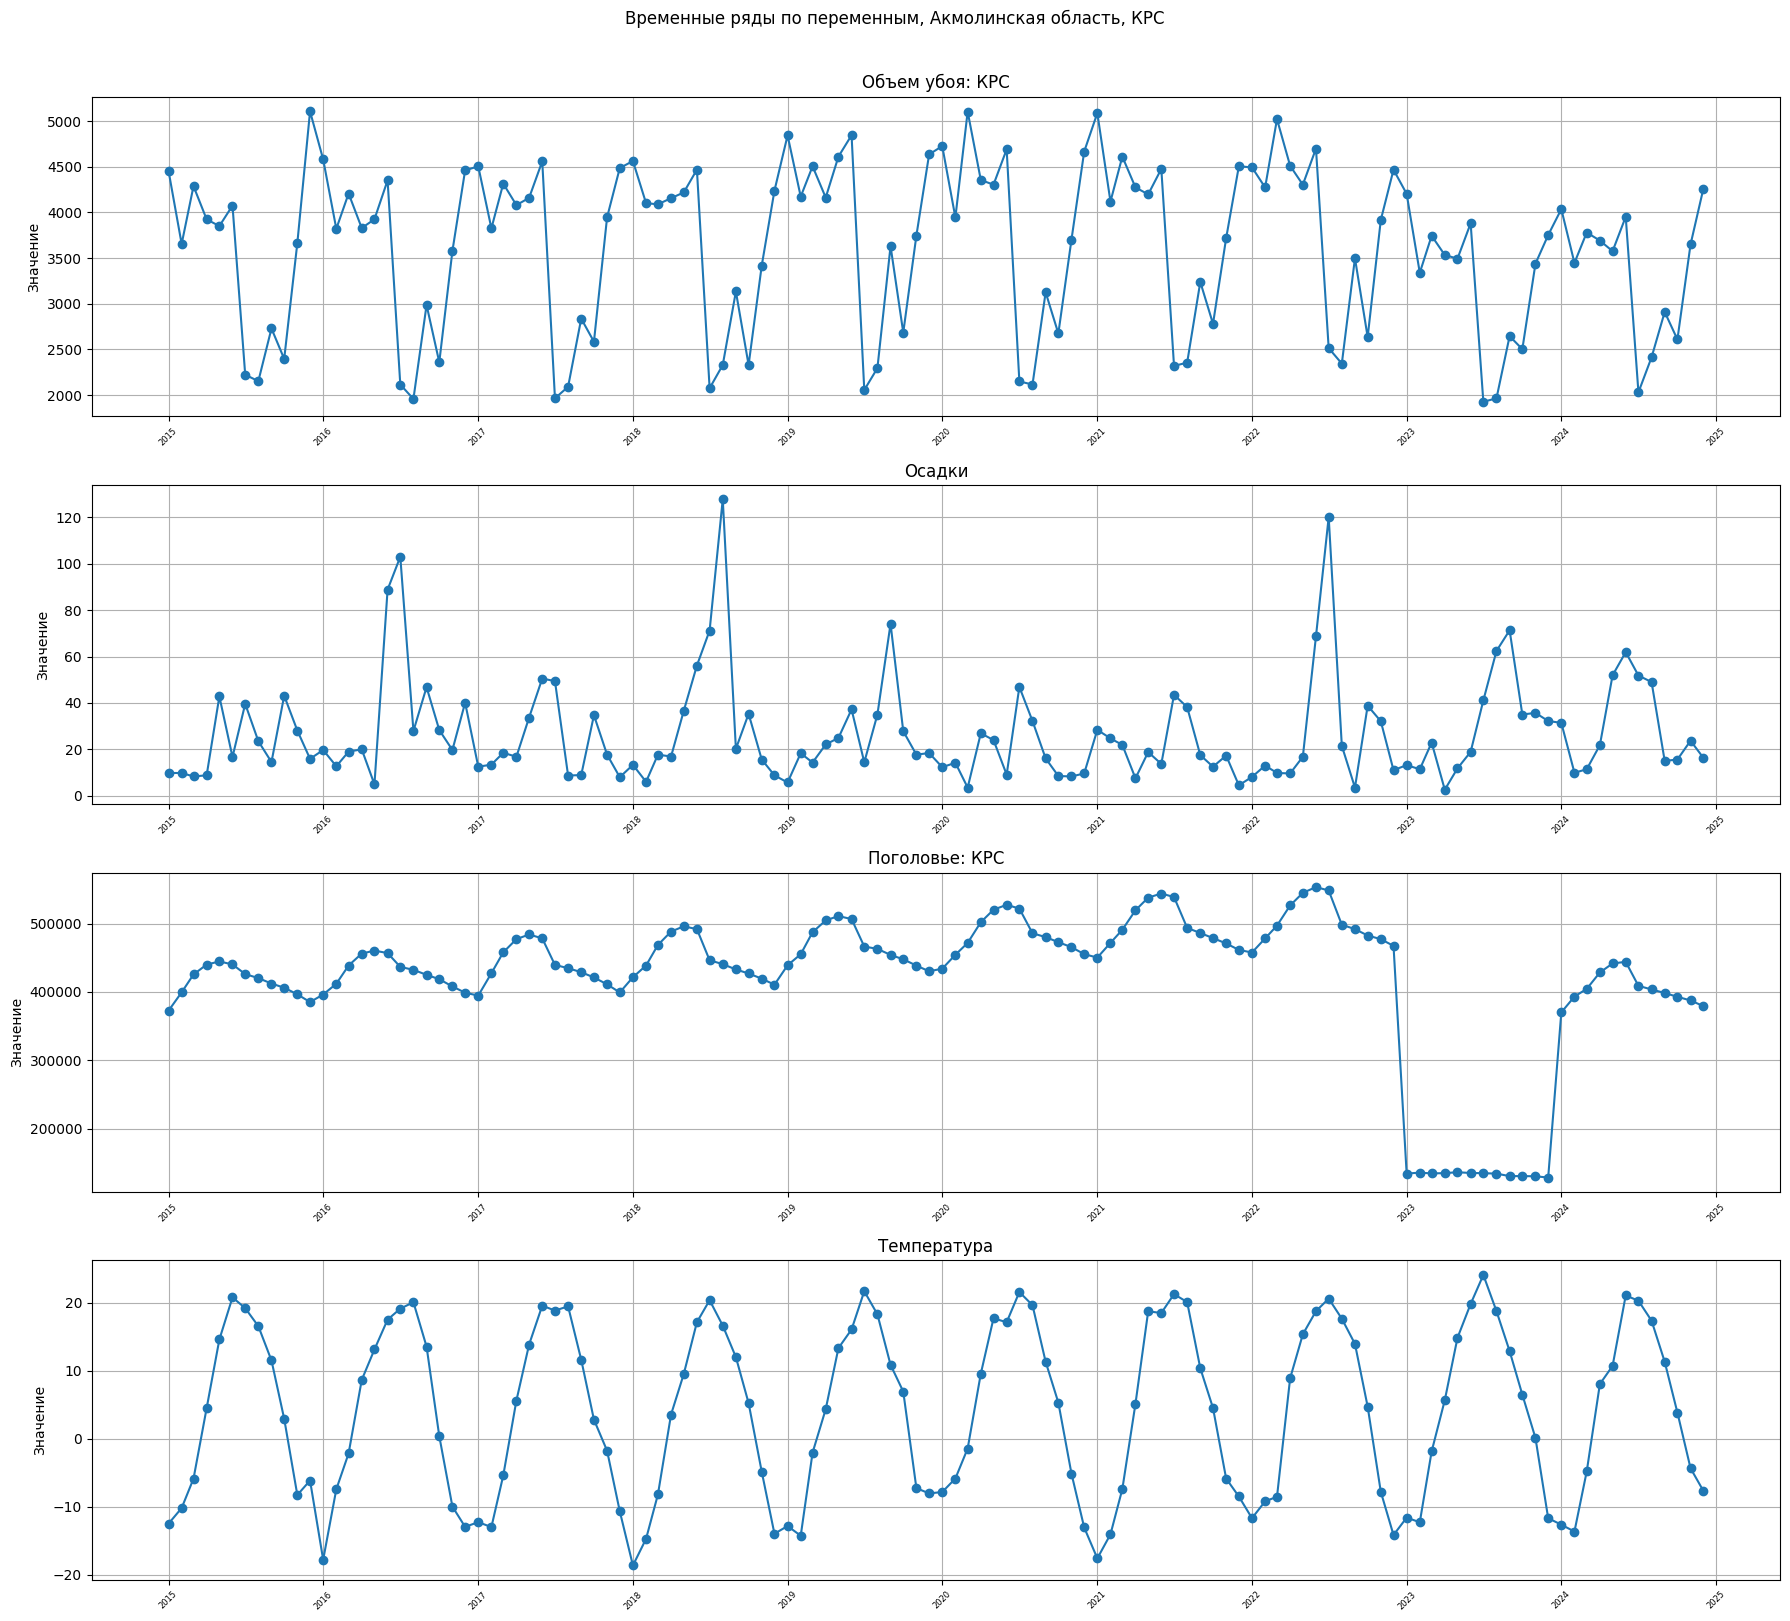

In [8]:
# Plot each variable in its own subplot
value_cols = [col for col in df_akmola.columns if col not in ["Период"]]

n = len(value_cols)
plt.figure(figsize=(18, 4 * n))

for i, col in enumerate(value_cols, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_akmola["Период"], df_akmola[col], marker="o")
    plt.title(f"{col}")
    plt.grid(True)
    plt.ylabel("Значение")
    plt.xticks(rotation=45, fontsize = 6)

plt.suptitle("Временные ряды по переменным, Акмолинская область, КРС", y=1.01)
plt.tight_layout()
plt.show()


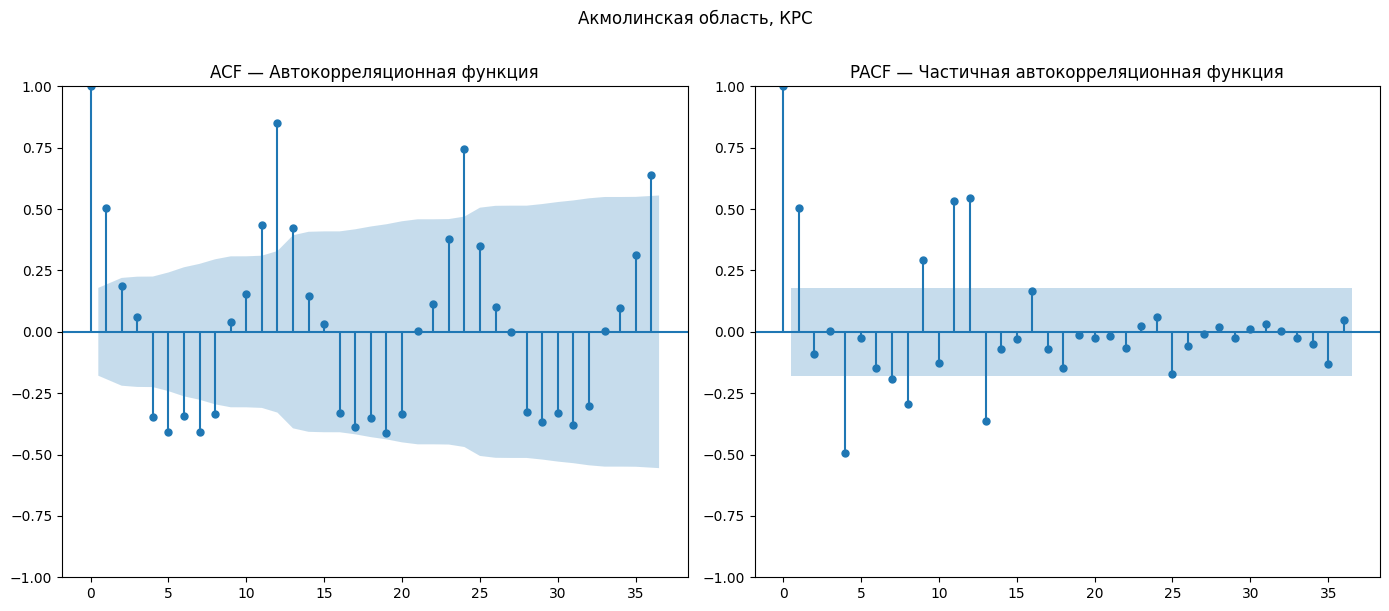

In [9]:
y = df_akmola["Объем убоя: КРС"].sort_index()

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y, lags=36, ax=plt.gca(), title="ACF — Автокорреляционная функция")

plt.subplot(1, 2, 2)
plot_pacf(y, lags=36, ax=plt.gca(), title="PACF — Частичная автокорреляционная функция", method="ywm")
plt.suptitle("Акмолинская область, КРС", y=1.01)

plt.tight_layout()
plt.show()

Графики автокорреляционной и частичной автокорреляционной функций указывают на **сильную взаимосвязь показателей текущего месяца со значениями предыдущего месяца** и на возможную **годовую сезонность** (пики на +12, +24 и +36 месяцев). 

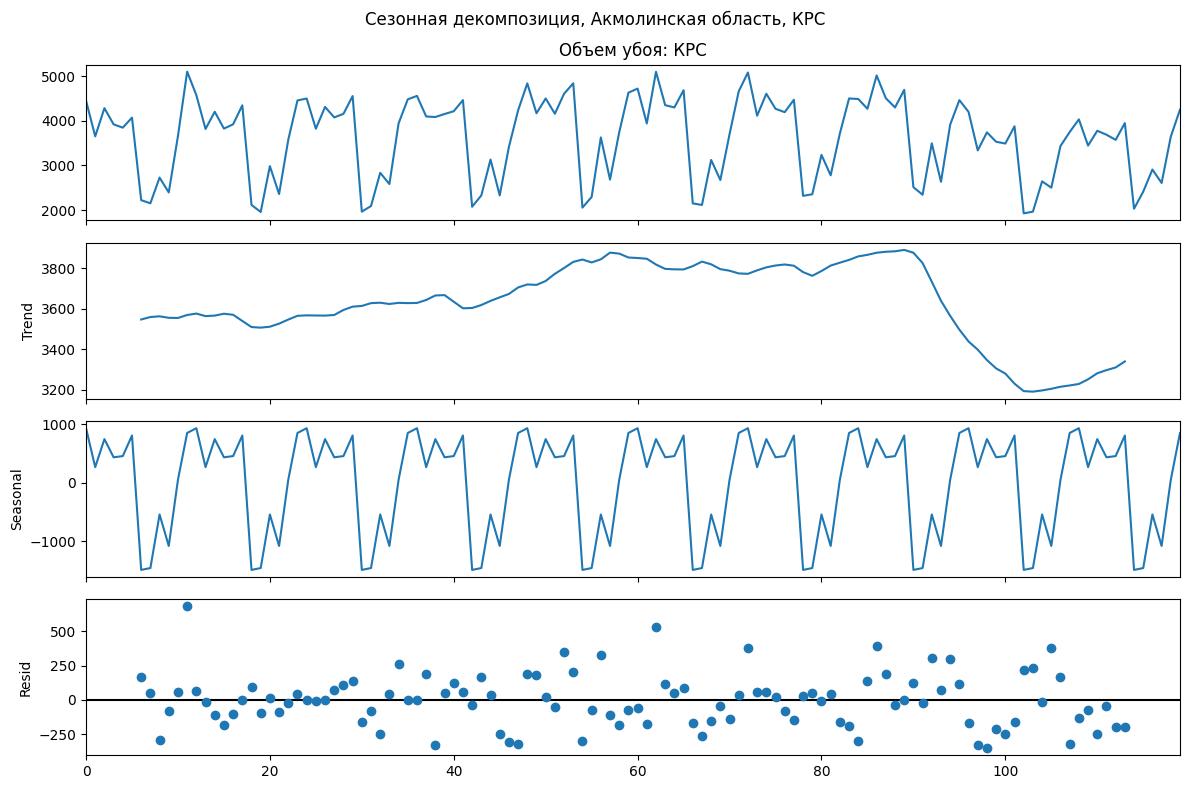

In [10]:
# Perform decomposition (period=12 for monthly data)
decomposition = seasonal_decompose(df_akmola["Объем убоя: КРС"], model="additive", period=12)

# Plot with larger figure size
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Сезонная декомпозиция, Акмолинская область, КРС", fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
# Run ADF test
result = adfuller(df_akmola["Объем убоя: КРС"])

# Display results
print("📊 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("✅ The series is likely **stationary** (reject H₀).")
else:
    print("❌ The series is likely **non-stationary** (fail to reject H₀).")


📊 Augmented Dickey-Fuller Test Results:
ADF Statistic: -1.2365
p-value: 0.6577
Critical Value (1%): -3.4930
Critical Value (5%): -2.8890
Critical Value (10%): -2.5814
❌ The series is likely **non-stationary** (fail to reject H₀).


Результаты теста ADF указывают на **нестационарность** временного ряда.

In [12]:
df_akmola

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
0,2015-01-01,4455.35,9.8,372560.0,-12.490323
1,2015-02-01,3654.20,9.8,399442.0,-10.192857
2,2015-03-01,4287.08,8.3,425605.0,-5.870968
3,2015-04-01,3923.21,8.8,440023.0,4.490000
4,2015-05-01,3849.70,42.8,444647.0,14.574194
...,...,...,...,...,...
115,2024-08-01,2412.70,49.0,403674.0,17.338710
116,2024-09-01,2909.66,15.0,398450.0,11.300000
117,2024-10-01,2608.27,15.6,392916.0,3.832258
118,2024-11-01,3649.19,23.7,387565.0,-4.343333


In [13]:
# Создание лагов t-1 до t-4 для переменных
for lag in range(1, 5):
    df_akmola[f"КРС_t-{lag}"] = df_akmola["Объем убоя: КРС"].shift(lag)
    df_akmola[f"Температура_t-{lag}"] = df_akmola["Температура"].shift(lag)
    df_akmola[f"Осадки_t-{lag}"] = df_akmola["Осадки"].shift(lag)
    df_akmola[f"Поголовье: КРС_t-{lag}"] = df_akmola["Поголовье: КРС"].shift(lag)

# Удаляем строки с NaN после сдвигов
df_akmola_lagged = df_akmola.dropna().copy()
df_akmola_lagged = df_akmola_lagged[["Период",
    "Объем убоя: КРС", "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4",
    "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4",
    "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4",
    "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4"]]

df_akmola_lagged

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
4,2015-05-01,3849.70,3923.21,4287.08,3654.20,4455.35,14.574194,4.490000,-5.870968,-10.192857,-12.490323,42.8,8.8,8.3,9.8,9.8,444647.0,440023.0,425605.0,399442.0,372560.0
5,2015-06-01,4074.13,3849.70,3923.21,4287.08,3654.20,20.763333,14.574194,4.490000,-5.870968,-10.192857,16.7,42.8,8.8,8.3,9.8,440238.0,444647.0,440023.0,425605.0,399442.0
6,2015-07-01,2221.96,4074.13,3849.70,3923.21,4287.08,19.180645,20.763333,14.574194,4.490000,-5.870968,39.6,16.7,42.8,8.8,8.3,426134.0,440238.0,444647.0,440023.0,425605.0
7,2015-08-01,2151.76,2221.96,4074.13,3849.70,3923.21,16.529032,19.180645,20.763333,14.574194,4.490000,23.5,39.6,16.7,42.8,8.8,420244.0,426134.0,440238.0,444647.0,440023.0
8,2015-09-01,2728.61,2151.76,2221.96,4074.13,3849.70,11.496667,16.529032,19.180645,20.763333,14.574194,14.5,23.5,39.6,16.7,42.8,412301.0,420244.0,426134.0,440238.0,444647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,2412.70,2029.47,3951.41,3574.86,3691.05,17.338710,20.270968,21.043333,10.696774,8.026667,49.0,51.8,61.9,51.9,21.8,403674.0,408936.0,444063.0,441647.0,428509.0
116,2024-09-01,2909.66,2412.70,2029.47,3951.41,3574.86,11.300000,17.338710,20.270968,21.043333,10.696774,15.0,49.0,51.8,61.9,51.9,398450.0,403674.0,408936.0,444063.0,441647.0
117,2024-10-01,2608.27,2909.66,2412.70,2029.47,3951.41,3.832258,11.300000,17.338710,20.270968,21.043333,15.6,15.0,49.0,51.8,61.9,392916.0,398450.0,403674.0,408936.0,444063.0
118,2024-11-01,3649.19,2608.27,2909.66,2412.70,2029.47,-4.343333,3.832258,11.300000,17.338710,20.270968,23.7,15.6,15.0,49.0,51.8,387565.0,392916.0,398450.0,403674.0,408936.0


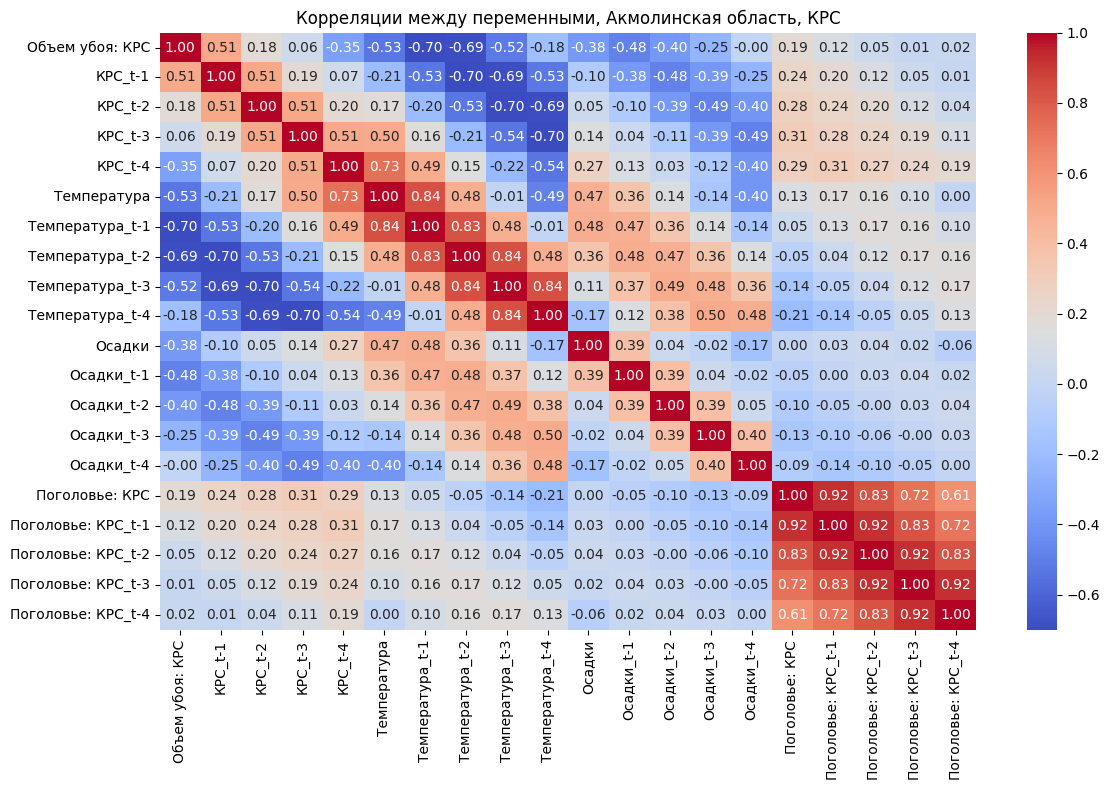

In [14]:
df_corr = df_akmola_lagged[[col for col in df_akmola_lagged.columns if col not in ["Период"]]].dropna()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, Акмолинская область, КРС")
plt.tight_layout()
plt.show()

* Умеренная позитивная корреляция (0.51) между показателями объема убоя за все соседствующие временные периоды: между t0 и t-1, t-1 и t-2 так далее. Это свидетельствует о наличии автокорреляции в данных: значения показателя в текущем месяце частично объясняются значениями в соседних месяцах. Это типичный признак временных рядов, особенно в аграрной статистике, где производственные процессы имеют инерционный характер. Это также означает, что модели авторегрессии (AR, ARIMA, SARIMA) могут хорошо работать на этих данных, так как текущие значения "похожи" на недавние;
* Корреляция между значениями обема убоя текущего месяца и предыдущих месяцев постепенно ослабевает, в особенности после лага в t-3. Это может быть связано с тем, что основной объём данных формируется за счёт отчетности крестьянских/фермерских хозяйств и хозяйств населения, которые сдают отчетность ежеквартально. В результате, месячные значения могут быть получены путём декомпозиции квартальных показателей, что сглаживает внутриквартальные различия, но снижает связь между кварталами.
* Температура и осадки, в том числе за предыдущие месяцы, умеренно негативно коррелируют с показателями обема убоя; 
* Между показателями объема убоя и поголовья в рамках значений текущего и предыдущего месяцев отмечается незначительная позитивная корреляция (0.19 и 0.12).

**МОЖНО ЕЩЕ ДОБАВИТЬ ВЫВОДЫ ПРИ НЕОБХОДИМОСТИ**

### Models

#### Многофакторная регрессия

In [15]:
df_akmola = df_akmola[["Период",
    "Объем убоя: КРС", "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4",
    "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4",
    "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4",
    "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4"]]
df_akmola

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
0,2015-01-01,4455.35,NaN,NaN,NaN,NaN,-12.490323,NaN,NaN,NaN,NaN,9.8,NaN,NaN,NaN,NaN,372560.0,NaN,NaN,NaN,NaN
1,2015-02-01,3654.20,4455.35,NaN,NaN,NaN,-10.192857,-12.490323,NaN,NaN,NaN,9.8,9.8,NaN,NaN,NaN,399442.0,372560.0,NaN,NaN,NaN
2,2015-03-01,4287.08,3654.20,4455.35,NaN,NaN,-5.870968,-10.192857,-12.490323,NaN,NaN,8.3,9.8,9.8,NaN,NaN,425605.0,399442.0,372560.0,NaN,NaN
3,2015-04-01,3923.21,4287.08,3654.20,4455.35,NaN,4.490000,-5.870968,-10.192857,-12.490323,NaN,8.8,8.3,9.8,9.8,NaN,440023.0,425605.0,399442.0,372560.0,NaN
4,2015-05-01,3849.70,3923.21,4287.08,3654.20,4455.35,14.574194,4.490000,-5.870968,-10.192857,-12.490323,42.8,8.8,8.3,9.8,9.8,444647.0,440023.0,425605.0,399442.0,372560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,2412.70,2029.47,3951.41,3574.86,3691.05,17.338710,20.270968,21.043333,10.696774,8.026667,49.0,51.8,61.9,51.9,21.8,403674.0,408936.0,444063.0,441647.0,428509.0
116,2024-09-01,2909.66,2412.70,2029.47,3951.41,3574.86,11.300000,17.338710,20.270968,21.043333,10.696774,15.0,49.0,51.8,61.9,51.9,398450.0,403674.0,408936.0,444063.0,441647.0
117,2024-10-01,2608.27,2909.66,2412.70,2029.47,3951.41,3.832258,11.300000,17.338710,20.270968,21.043333,15.6,15.0,49.0,51.8,61.9,392916.0,398450.0,403674.0,408936.0,444063.0
118,2024-11-01,3649.19,2608.27,2909.66,2412.70,2029.47,-4.343333,3.832258,11.300000,17.338710,20.270968,23.7,15.6,15.0,49.0,51.8,387565.0,392916.0,398450.0,403674.0,408936.0


In [16]:
df_akmola_lagged

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
4,2015-05-01,3849.70,3923.21,4287.08,3654.20,4455.35,14.574194,4.490000,-5.870968,-10.192857,-12.490323,42.8,8.8,8.3,9.8,9.8,444647.0,440023.0,425605.0,399442.0,372560.0
5,2015-06-01,4074.13,3849.70,3923.21,4287.08,3654.20,20.763333,14.574194,4.490000,-5.870968,-10.192857,16.7,42.8,8.8,8.3,9.8,440238.0,444647.0,440023.0,425605.0,399442.0
6,2015-07-01,2221.96,4074.13,3849.70,3923.21,4287.08,19.180645,20.763333,14.574194,4.490000,-5.870968,39.6,16.7,42.8,8.8,8.3,426134.0,440238.0,444647.0,440023.0,425605.0
7,2015-08-01,2151.76,2221.96,4074.13,3849.70,3923.21,16.529032,19.180645,20.763333,14.574194,4.490000,23.5,39.6,16.7,42.8,8.8,420244.0,426134.0,440238.0,444647.0,440023.0
8,2015-09-01,2728.61,2151.76,2221.96,4074.13,3849.70,11.496667,16.529032,19.180645,20.763333,14.574194,14.5,23.5,39.6,16.7,42.8,412301.0,420244.0,426134.0,440238.0,444647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,2412.70,2029.47,3951.41,3574.86,3691.05,17.338710,20.270968,21.043333,10.696774,8.026667,49.0,51.8,61.9,51.9,21.8,403674.0,408936.0,444063.0,441647.0,428509.0
116,2024-09-01,2909.66,2412.70,2029.47,3951.41,3574.86,11.300000,17.338710,20.270968,21.043333,10.696774,15.0,49.0,51.8,61.9,51.9,398450.0,403674.0,408936.0,444063.0,441647.0
117,2024-10-01,2608.27,2909.66,2412.70,2029.47,3951.41,3.832258,11.300000,17.338710,20.270968,21.043333,15.6,15.0,49.0,51.8,61.9,392916.0,398450.0,403674.0,408936.0,444063.0
118,2024-11-01,3649.19,2608.27,2909.66,2412.70,2029.47,-4.343333,3.832258,11.300000,17.338710,20.270968,23.7,15.6,15.0,49.0,51.8,387565.0,392916.0,398450.0,403674.0,408936.0


In [17]:
df_vif = df_akmola_lagged[[col for col in df_akmola_lagged.columns if col not in ["Период"]]]

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data

,Variable,VIF
0,const,196.640560
1,КРС_t-1,3.000134
2,КРС_t-2,2.792945
3,КРС_t-3,2.834054
4,КРС_t-4,3.313961
5,Температура,22.493800
6,Температура_t-1,20.820626
7,Температура_t-2,23.347806
8,Температура_t-3,21.580502
9,Температура_t-4,20.051279


In [18]:
def forward_selection(data, target, candidate_features, criterion="adj_r2"):
    remaining = list(candidate_features)
    selected = []
    best_score = -float("inf")
    best_model = None

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            X = sm.add_constant(data[features])
            y = data[target]
            model = sm.OLS(y, X).fit()

            if criterion == "adj_r2":
                score = model.rsquared_adj
            elif criterion == "aic":
                score = -model.aic  # negative for maximizing
            else:
                raise ValueError("criterion must be 'adj_r2' or 'aic'")

            scores_with_candidates.append((score, candidate, model))

        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate, model = scores_with_candidates[0]

        if best_new_score > best_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            best_score = best_new_score
            best_model = model
            print(f"✅ Added: {best_candidate}, {criterion.upper()}: {best_score:.4f}")
        else:
            print("⛔ No improvement. Stopping.")
            break

    return selected, best_model


In [19]:
# Define target and candidate predictors
target = "Объем убоя: КРС"
candidate_features = ['Осадки', 'Осадки_t-3', 'Осадки_t-2', 'Осадки_t-1',
    'Температура', 'Температура_t-3', 'Температура_t-2', 'Температура_t-1',
    'Поголовье: КРС', 'Поголовье: КРС_t-3', 'Поголовье: КРС_t-2', 'Поголовье: КРС_t-1',
    'КРС_t-4', 'КРС_t-3', 'КРС_t-2', 'КРС_t-1']

# Drop rows with missing values
df_mlr = df_akmola[candidate_features + [target]].dropna()

# Run forward selection
selected_features, final_model = forward_selection(df_mlr, target, candidate_features, criterion="adj_r2")

# Show final summary

print(selected_features)
print("\n🧾 Final Model Summary:")
print(final_model.summary())



✅ Added: Температура_t-1, ADJ_R2: 0.4866
✅ Added: Поголовье: КРС, ADJ_R2: 0.5341
✅ Added: Температура_t-3, ADJ_R2: 0.5612
✅ Added: КРС_t-4, ADJ_R2: 0.6076
✅ Added: КРС_t-2, ADJ_R2: 0.6682
✅ Added: Осадки_t-1, ADJ_R2: 0.6729
✅ Added: Осадки_t-3, ADJ_R2: 0.6772
✅ Added: Поголовье: КРС_t-1, ADJ_R2: 0.6804
⛔ No improvement. Stopping.
['Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1']

🧾 Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:        Объем убоя: КРС   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     31.61
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           6.66e-25
Time:                        11:23:29   Log-Likelihood:                -884.84
No. Observations:                 116   A

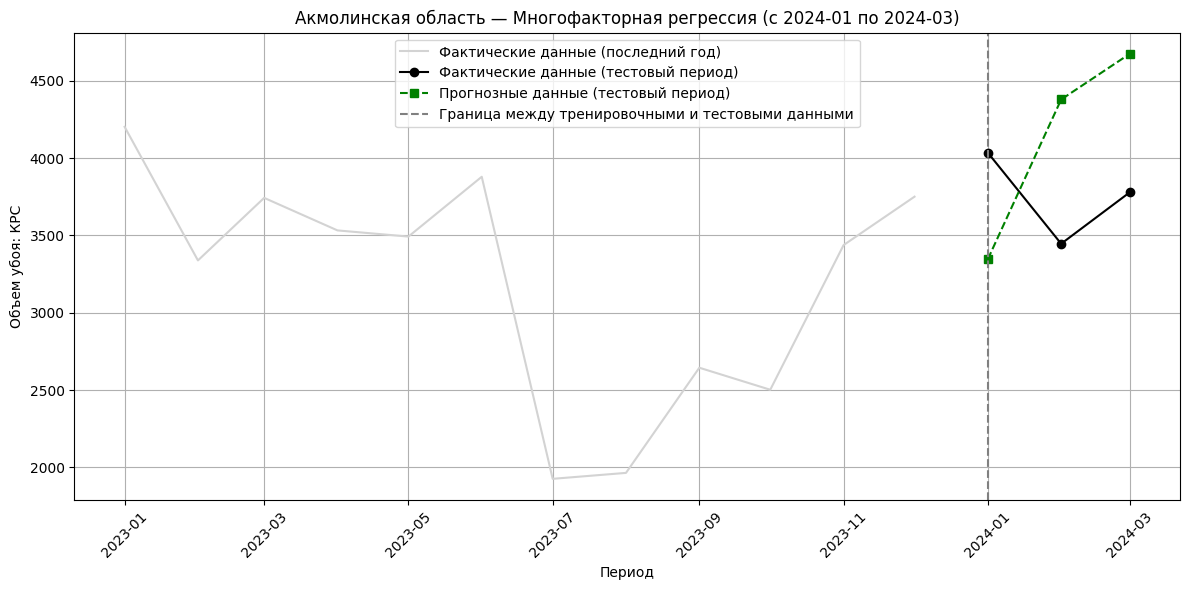

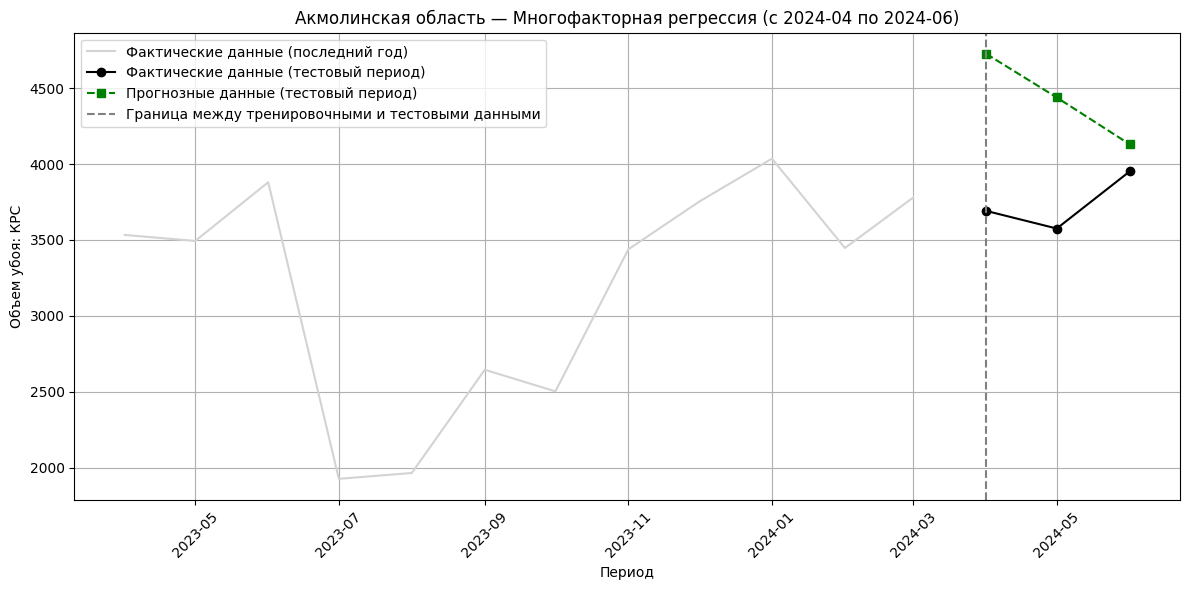

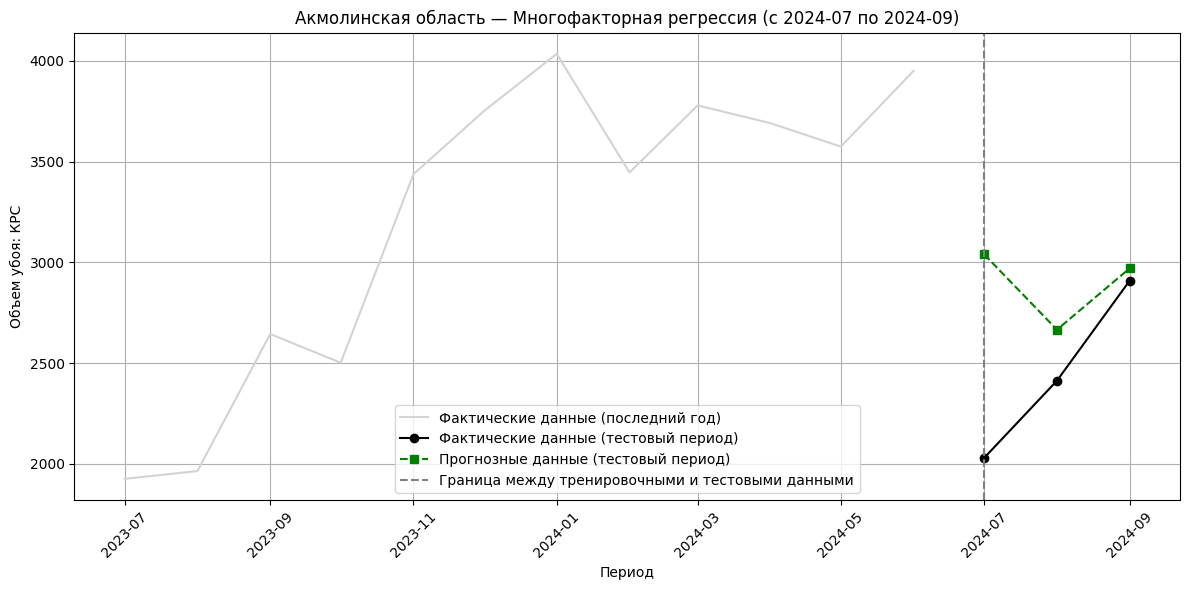

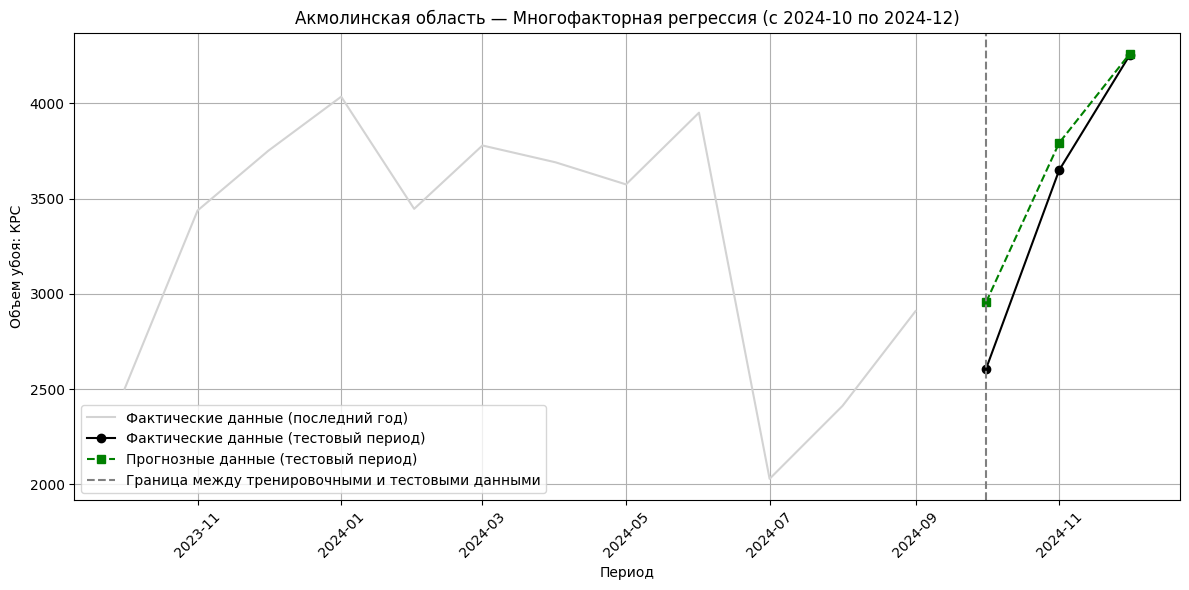

In [20]:
# Ensure your dataframe is sorted by time
df = df_akmola.sort_values("Период").dropna().copy()

# # Selected features
# selected_features = [
#     'Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1'
# ]

target = "Объем убоя: КРС"
results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    # Drop NAs and align predictors
    X_train = sm.add_constant(train_df[selected_features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[selected_features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    # print(y_test, '\n', y_pred, '\n', y_test-y_pred)

    r2 = r2_score(y_test, y_pred)
    # print("Zero values in y_test:", (y_test == 0).sum())


    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [21]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period        RMSE         MAE   MAPE (%)
0  2024-01 to 2024-03  846.209542  839.340520  22.618331
1  2024-04 to 2024-06  784.990055  692.244902  18.902098
2  2024-07 to 2024-09  602.449671  441.626082  20.795883
3  2024-10 to 2024-12  217.971058  166.451109   5.825390
4             Average  612.905082  534.915653  17.035426


In [22]:
df_akmola

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
0,2015-01-01,4455.35,NaN,NaN,NaN,NaN,-12.490323,NaN,NaN,NaN,NaN,9.8,NaN,NaN,NaN,NaN,372560.0,NaN,NaN,NaN,NaN
1,2015-02-01,3654.20,4455.35,NaN,NaN,NaN,-10.192857,-12.490323,NaN,NaN,NaN,9.8,9.8,NaN,NaN,NaN,399442.0,372560.0,NaN,NaN,NaN
2,2015-03-01,4287.08,3654.20,4455.35,NaN,NaN,-5.870968,-10.192857,-12.490323,NaN,NaN,8.3,9.8,9.8,NaN,NaN,425605.0,399442.0,372560.0,NaN,NaN
3,2015-04-01,3923.21,4287.08,3654.20,4455.35,NaN,4.490000,-5.870968,-10.192857,-12.490323,NaN,8.8,8.3,9.8,9.8,NaN,440023.0,425605.0,399442.0,372560.0,NaN
4,2015-05-01,3849.70,3923.21,4287.08,3654.20,4455.35,14.574194,4.490000,-5.870968,-10.192857,-12.490323,42.8,8.8,8.3,9.8,9.8,444647.0,440023.0,425605.0,399442.0,372560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,2412.70,2029.47,3951.41,3574.86,3691.05,17.338710,20.270968,21.043333,10.696774,8.026667,49.0,51.8,61.9,51.9,21.8,403674.0,408936.0,444063.0,441647.0,428509.0
116,2024-09-01,2909.66,2412.70,2029.47,3951.41,3574.86,11.300000,17.338710,20.270968,21.043333,10.696774,15.0,49.0,51.8,61.9,51.9,398450.0,403674.0,408936.0,444063.0,441647.0
117,2024-10-01,2608.27,2909.66,2412.70,2029.47,3951.41,3.832258,11.300000,17.338710,20.270968,21.043333,15.6,15.0,49.0,51.8,61.9,392916.0,398450.0,403674.0,408936.0,444063.0
118,2024-11-01,3649.19,2608.27,2909.66,2412.70,2029.47,-4.343333,3.832258,11.300000,17.338710,20.270968,23.7,15.6,15.0,49.0,51.8,387565.0,392916.0,398450.0,403674.0,408936.0


#### ARIMA/SARIMA/SARIMAX

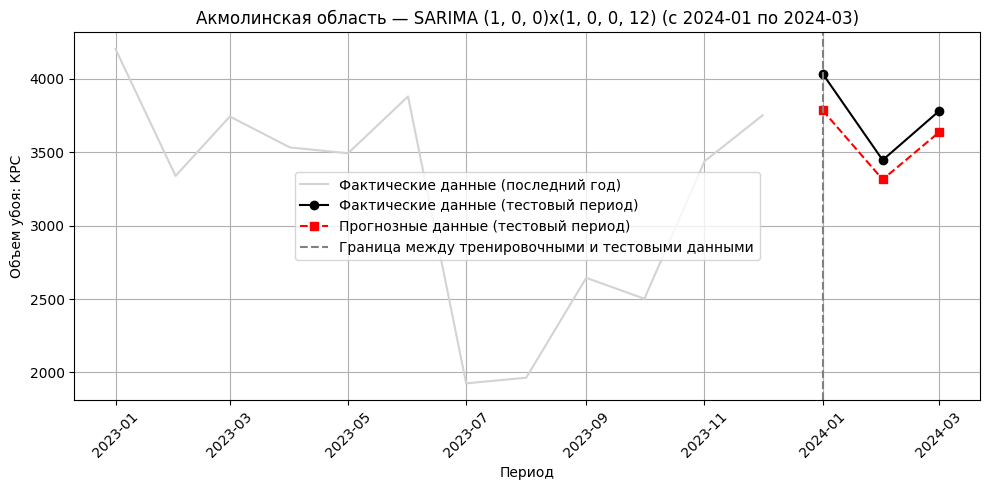

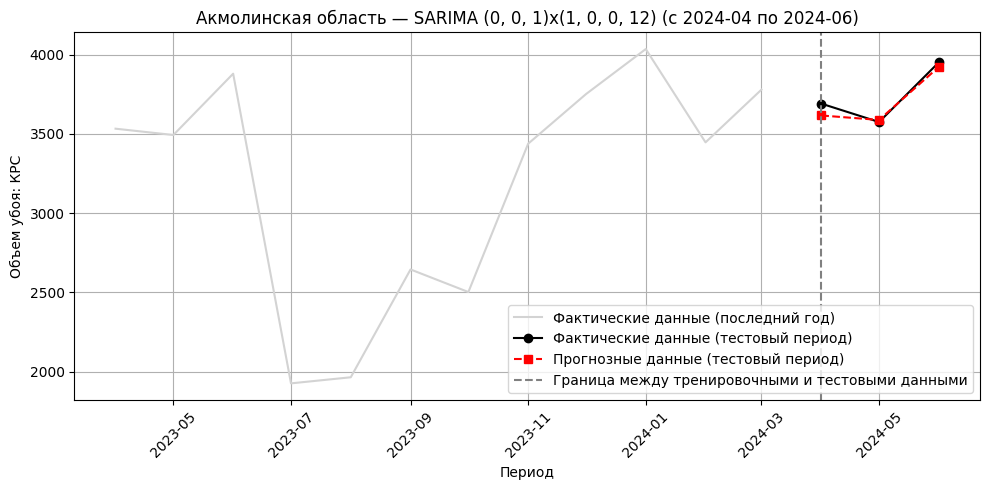

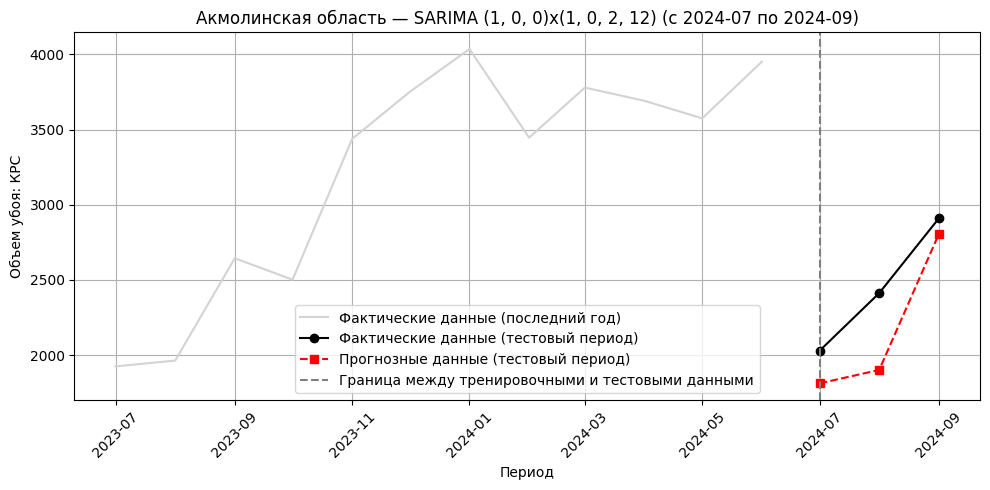

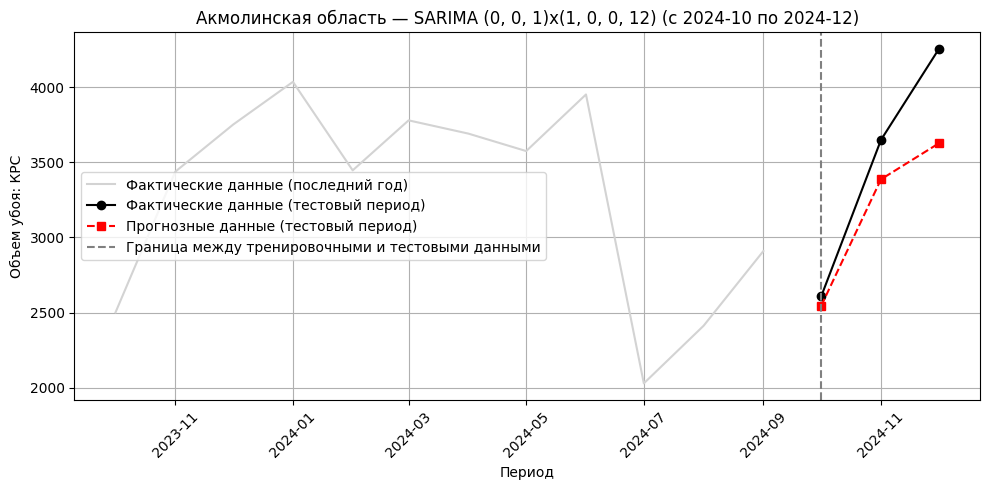

In [23]:
df = df_akmola.sort_values("Период").copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)
        # forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
        # print(y_test, '\n', forecast, '\n', y_test-forecast)
        # print("Are indices equal?", y_test.index.equals(forecast.index))



        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMA {model.order}x{model.seasonal_order} (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [24]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period        RMSE         MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  183.269260  175.509779   4.616666    (1, 0, 0)   
1  2024-04 to 2024-06   46.924346   38.944970   1.041897    (0, 0, 1)   
2  2024-07 to 2024-09  325.969456  277.282038  11.811754    (1, 0, 0)   
3  2024-10 to 2024-12  394.156256  317.396610   8.112661    (0, 0, 1)   
4             Average  237.579830  202.283349   6.395744          NaN   

  Seasonal order  
0  (1, 0, 0, 12)  
1  (1, 0, 0, 12)  
2  (1, 0, 2, 12)  
3  (1, 0, 0, 12)  
4            NaN  


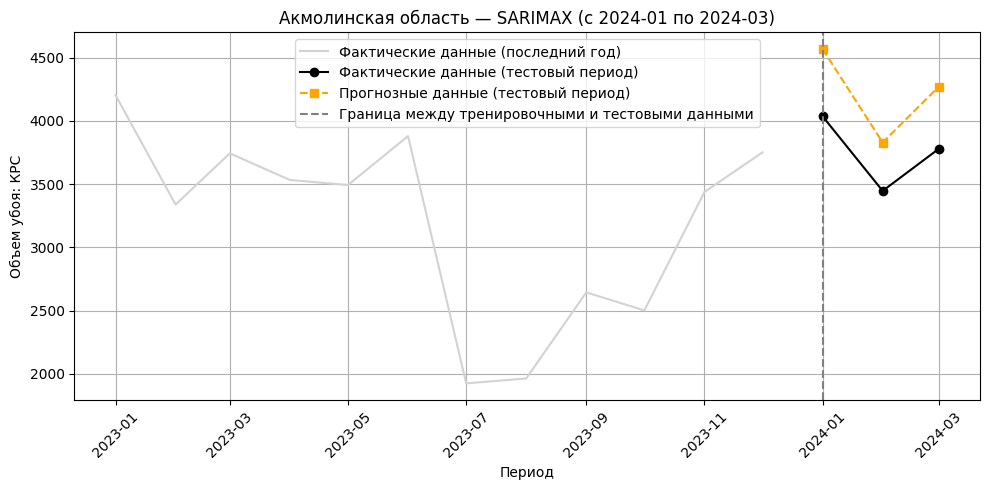

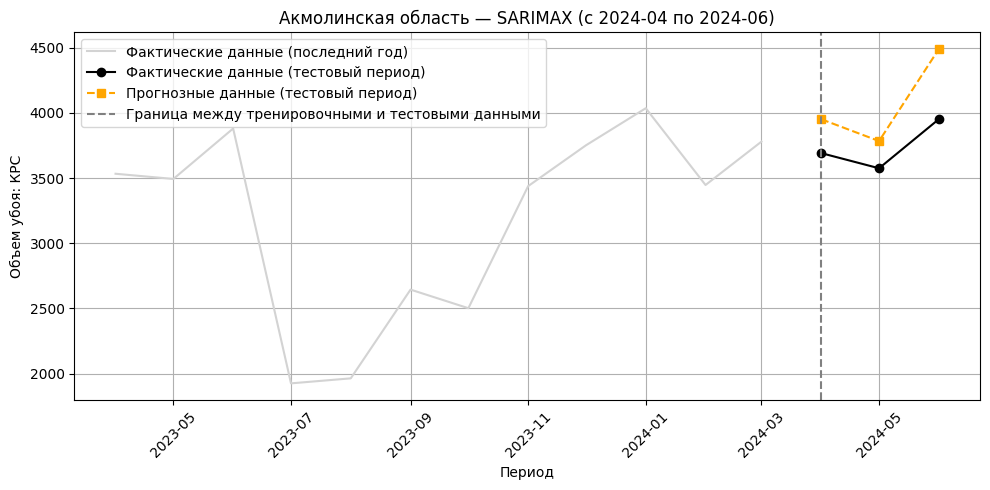

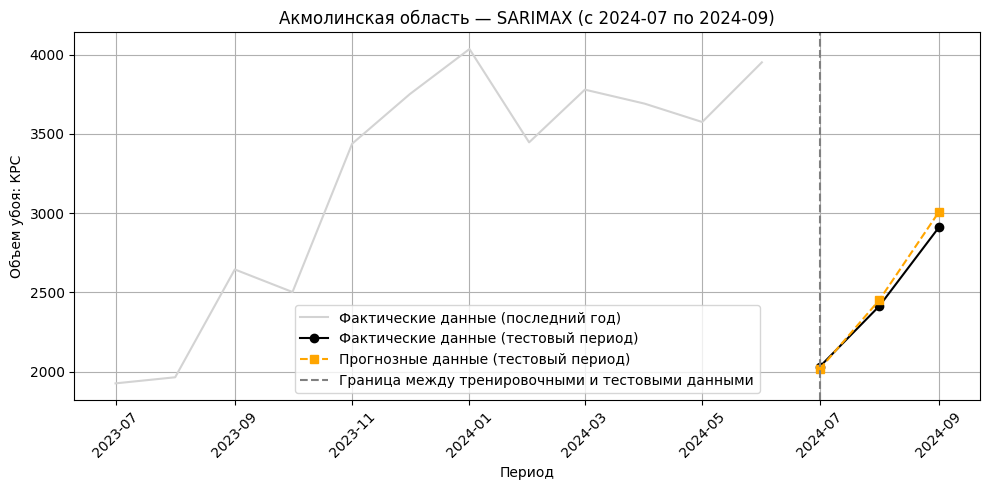

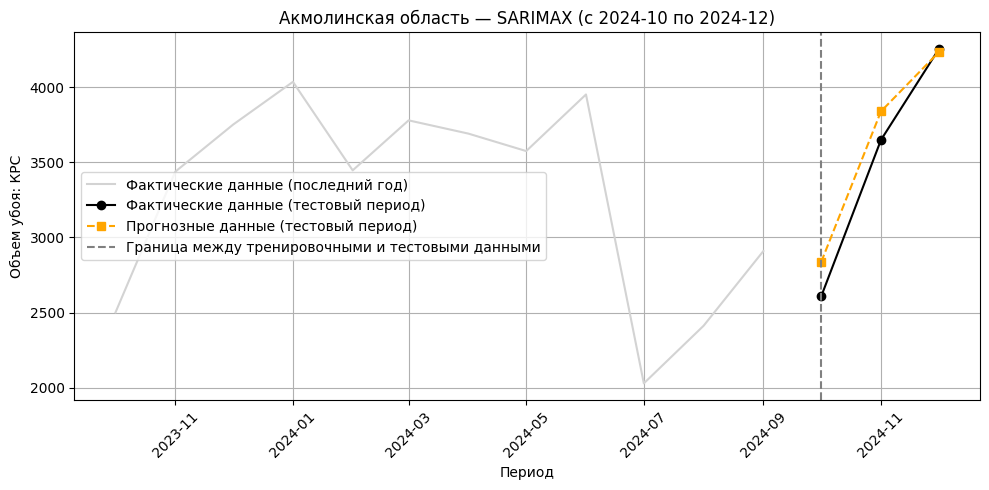

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your exogenous variables
exog_vars = ['Температура_t-1', 'Поголовье: КРС']

df = df_akmola.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[exog_vars].reset_index(drop=True)
    exog_test = test_df[exog_vars].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 0, 1),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [26]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



          Test period        RMSE         MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  472.796123  468.548312  12.425620            0   
1  2024-04 to 2024-06  365.173493  335.363988   8.827223            0   
2  2024-07 to 2024-09   60.776988   49.903295   1.877417            0   
3  2024-10 to 2024-12  172.142168  146.420591   4.820680            0   
4             Average  267.722193  250.059046   6.987735                

  Seasonal order  
0             12  
1             12  
2             12  
3             12  
4                 


#### Prophet

11:24:17 - cmdstanpy - INFO - Chain [1] start processing
11:24:17 - cmdstanpy - INFO - Chain [1] done processing


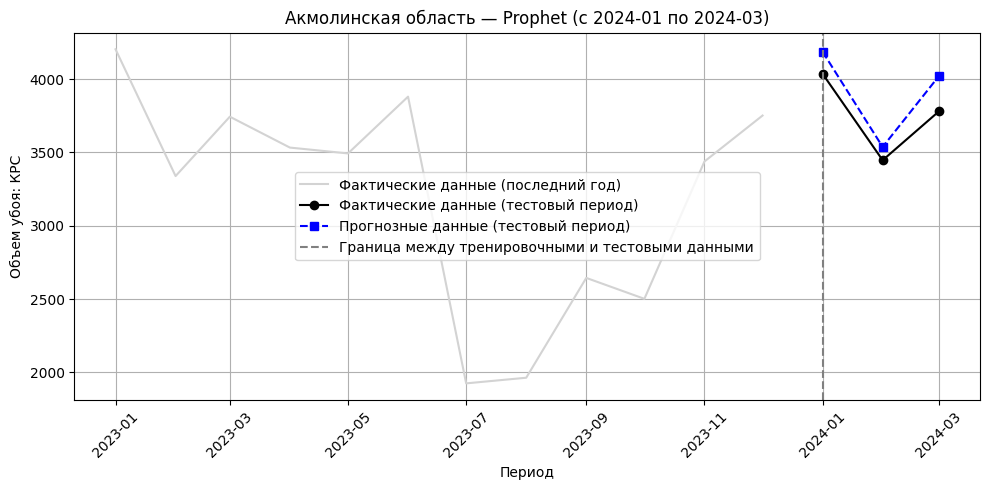

11:24:18 - cmdstanpy - INFO - Chain [1] start processing
11:24:18 - cmdstanpy - INFO - Chain [1] done processing


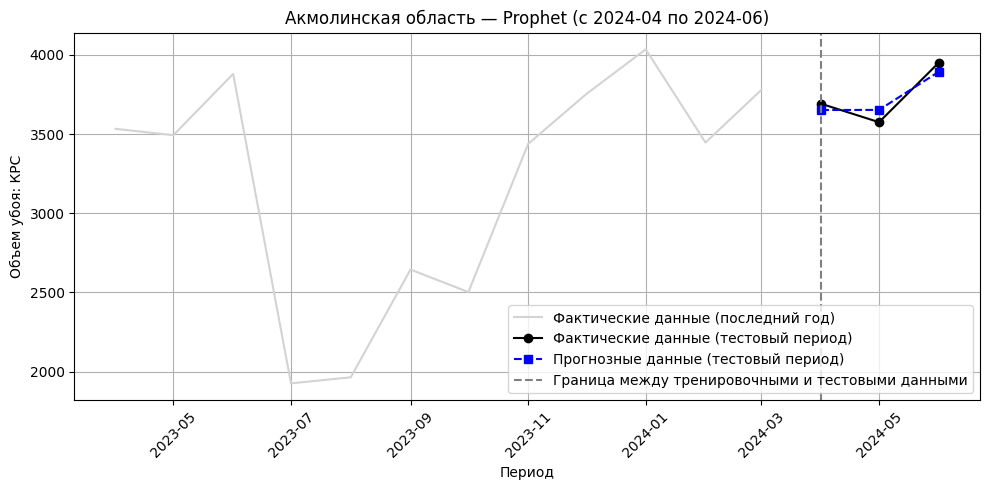

11:24:18 - cmdstanpy - INFO - Chain [1] start processing
11:24:18 - cmdstanpy - INFO - Chain [1] done processing


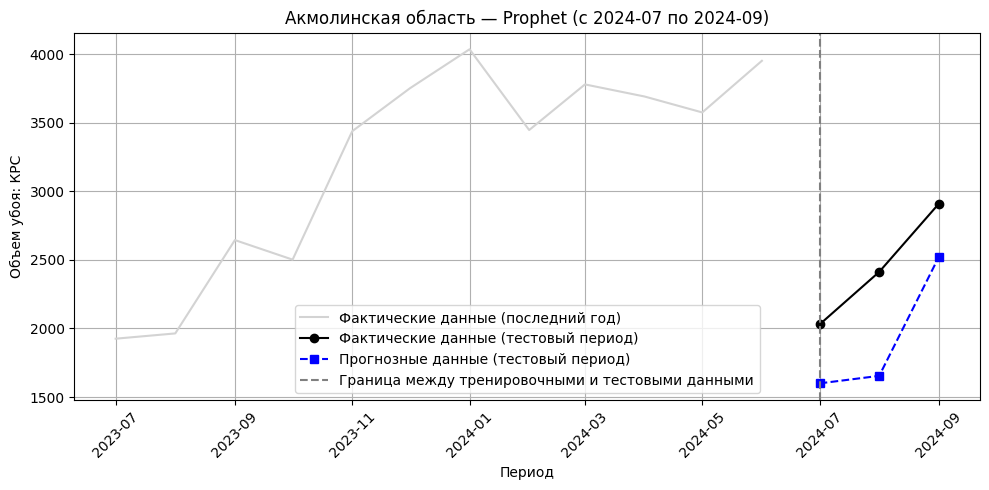

11:24:19 - cmdstanpy - INFO - Chain [1] start processing
11:24:19 - cmdstanpy - INFO - Chain [1] done processing


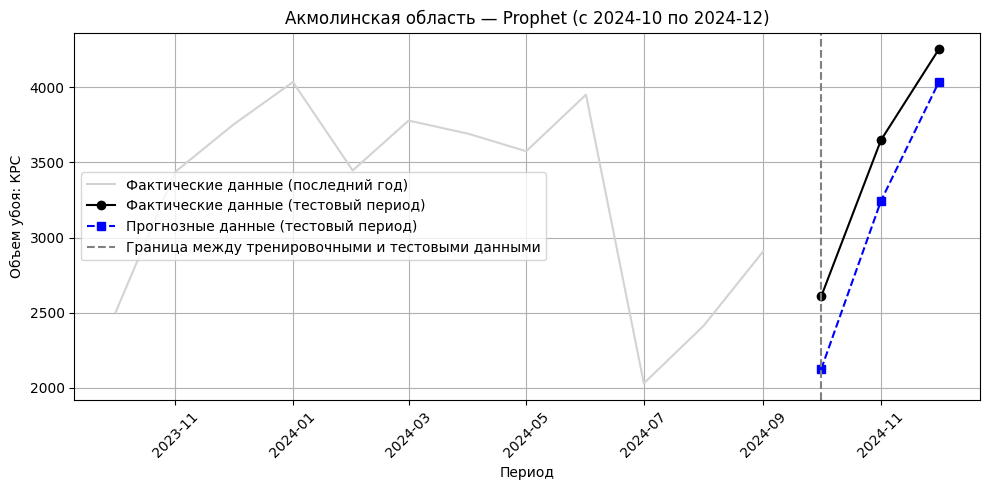

In [27]:
# Prepare Data
df = df_akmola.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура")
    # model.add_regressor("Осадки")
    # model.add_regressor("Поголовье: КРС")
    # prophet_train["Температура"] = train_df["Температура"].values
    # prophet_test["Температура"] = test_df["Температура"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [28]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

          Test period        RMSE         MAE   MAPE (%)
0  2024-01 to 2024-03  171.715022  160.312432   4.235089
1  2024-04 to 2024-06   60.394655   58.312650   1.568201
2  2024-07 to 2024-09  550.506486  525.013161  21.966202
3  2024-10 to 2024-12  385.444993  369.042283  11.592784
4             Average  292.015289  278.170131   9.840569


strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation